# Tutorial: detecting label errors in a dataset

## Q: What are samples with label errors?

A figure below illustrates what are samples with label errors.

In [1]:
# Set path
import sys
import os
os.chdir('..')
o_path = os.getcwd()
print(o_path)
sys.path.append(o_path) # set path so that modules from other foloders can be loaded
from IPython.display import Image

/home/albert/repos/ajms/docta


#### The figure above includes 10 selected CIFAR-100N images with ground-truth labels (first row in text) and human annotated labels (second row in text). Images with red-circled text indicate that their ``human annotations`` differ from the ``ground-truth label``. Thus, there exists label error in images with red-circled labels.

### Don't worry about label errors in your data. Docta can help you detecting them!

## Docta Experiment Image Classification

In [2]:
import torch
torch.cuda.set_device(0)
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 4070 Laptop GPU'

In [3]:
%run ./tools/docta_image_classification.py

==== Docta: Doctor for your data. Current version: 0.2 ====
idx range for training data [0]
#Samples (dataset-train) 19360.
Estimating consensus patterns...


100%|██████████| 50/50 [01:00<00:00,  1.20s/it]


Estimating consensus patterns... [Done]
Use cpu to solve equations


100%|██████████| 1501/1501 [00:30<00:00, 49.15it/s]


Solve equations... [Done]
T_est is 
[[86.6  2.8  1.5  0.3  1.1  2.1  2.8  1.1  1.2  0.5]
 [ 0.4 94.   1.2  1.4  0.2  1.1  0.5  0.2  0.8  0.2]
 [ 1.8  4.8 77.3  1.9  1.2  2.7  5.   1.8  2.3  1.3]
 [ 0.2  1.9  0.7 79.2  1.9 14.3  0.4  0.1  1.   0.3]
 [ 0.9  0.6  0.9  4.2 78.7  9.6  2.1  0.6  1.2  1. ]
 [ 1.   1.2  0.8 11.6  5.2 73.9  3.9  0.1  2.1  0.1]
 [ 1.4  0.9  1.2  0.7  1.   4.9 88.1  0.3  1.2  0.3]
 [ 1.9  1.5  2.9  0.1  1.3  0.2  1.7 89.   0.7  0.7]
 [ 1.3  2.5  2.4  1.4  1.   5.2  2.6  0.6 82.6  0.5]
 [ 0.7  0.7  1.5  1.7  2.4  0.5  0.9  0.4  0.6 90.6]]
p_est is 
[[ 5.2]
 [12.2]
 [ 6.9]
 [16. ]
 [ 9.3]
 [26.8]
 [15.2]
 [ 1.6]
 [ 3.4]
 [ 3.4]]
Detecting label errors with simifeat.
Use SimiFeat-rank to detect label errors.


100%|██████████| 21/21 [00:17<00:00,  1.19it/s]

[SimiFeat] We find 3397 corrupted instances from 19360 instances


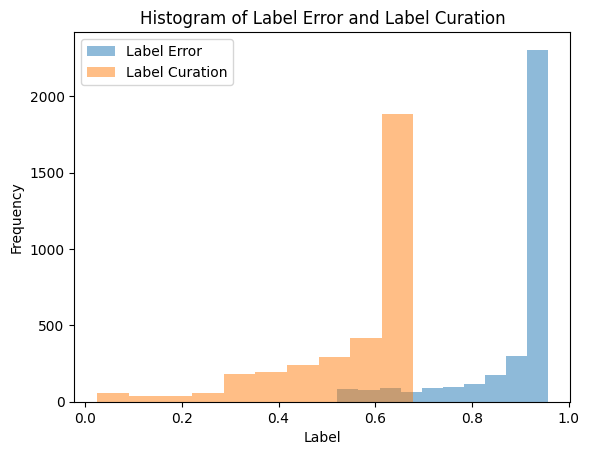

In [5]:
import matplotlib.pyplot as plt

plt.hist(label_error[:,1], alpha=0.5, label='Label Error')
plt.hist(label_curation[:,2], alpha=0.5, label='Label Curation')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Histogram of Label Error and Label Curation')
plt.legend()
plt.show()

In [6]:
sel = (label_curation[:, 2] > 0.6) & (label_error[:, 1] > 0.95)
print(f"Found {np.sum(sel)} label errors from {len(dataset_raw)} samples")

# generate cured labels
cured_labels = np.array(dataset_raw.label)
cured_labels[label_curation[sel, 0].astype(int)] = label_curation[sel, 1].astype(int)
save_path = cfg.save_path + f"cured_labels_{cfg.dataset_type}.pt"
torch.save(cured_labels, save_path)
print(f"Saved cured labels to {save_path}")


Found 1204 label errors from 19360 samples
Saved cured labels to ./results/IMAGE_CLASSIFICATION_p10/cured_labels_IMAGE_CLASSIFICATION_p10.pt


## Load cured labels

In [7]:
cured_labels = torch.load('./results/IMAGE_CLASSIFICATION_p10/cured_labels_IMAGE_CLASSIFICATION_p10.pt')

## A help function for visualization

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
def visualize_result(num_show, data, noisy_label, cured_labels, label_name):
    plt.rcParams["figure.figsize"] = (20,24)
    size = num_show
    width = int(size / 3)
    cnt = 0
    for i in range(len(dataset)):
        if noisy_label[i] != cured_labels[i]:
            ax = plt.subplot(width,3,cnt+1)
            ax.imshow(data.feature[i])
            ax.set_title(f'Expert: {label_name[noisy_label[i]]}.\nSuggested: {label_name[cured_labels[i]]}.')
            ax.axis('off')
            cnt += 1
        if cnt == num_show:
            break
    plt.show()

## Visualize results

Processing Images: 100%|██████████| 19360/19360 [00:00<00:00, 35046.47it/s]


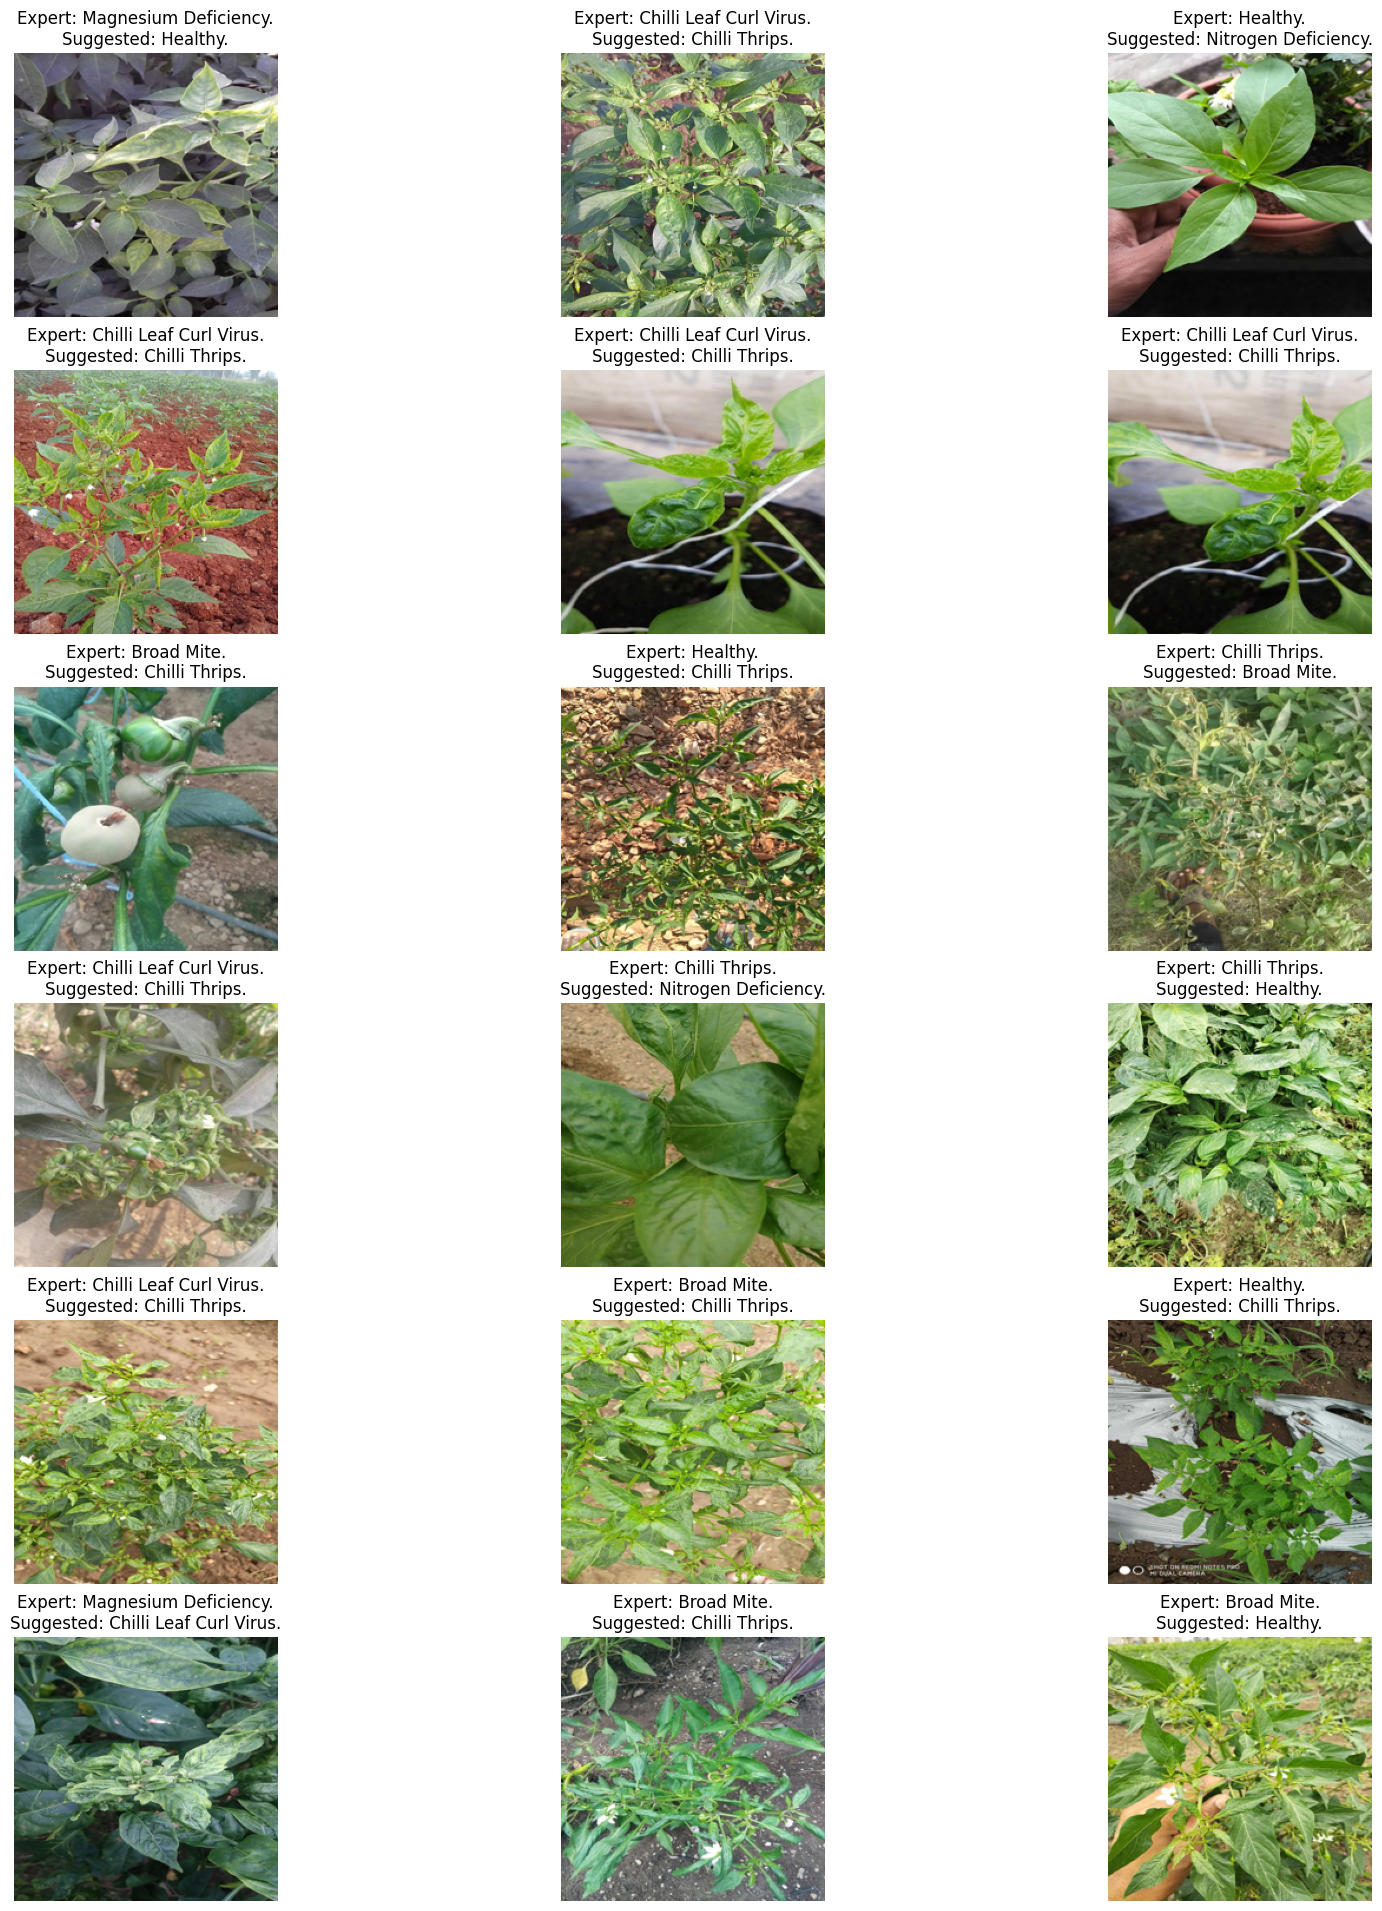

In [9]:
dataset = ImageDataset10Classes(cfg, train=True)
noisy_label = dataset.label
feature = dataset.feature
label_name = [index_to_class[idx] for idx in range(len(index_to_class))]
num_show = 18
visualize_result(num_show, dataset, noisy_label, cured_labels, label_name)
